The mathematical formula for ARIMA(p,d,q) is as follows

`y{t} = c + ϕy{t-1} + ... + ϕ{p} y{t-p} + ε{t} + θε{t-1} + ... + θ{q}ε{t-q}`

ARIMA model in words:

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)`

In [2]:
# Reference Material - 
# https://alkaline-ml.com/pmdarima/quickstart.html
# https://alkaline-ml.com/pmdarima/usecases/sun-spots.html
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import pmdarima as pm
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [3]:
pm.show_versions()


System:
    python: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
executable: C:\ProgramData\anaconda3\envs\clouds\python.exe
   machine: Windows-10-10.0.22621-SP0

Python dependencies:
 setuptools: 68.0.0
        pip: 23.3
    sklearn: 1.2.2
statsmodels: 0.14.0
      numpy: 1.26.0
      scipy: 1.11.3
     Cython: 3.0.5
     pandas: 2.1.1
     joblib: 1.2.0
   pmdarima: 2.0.4


In [4]:
df = pd.read_pickle('df_timeseries.pickle')
df_arima = df.copy()

df_arima.groupby(['nprb_id','new_time'])

#Extracting the results of one probe and destination
df_arima = df_arima[(df_arima['nprb_id'] == 'es1') & (df_arima['dst_addr'] == "52.46.200.93")]
df_arima = df_arima.set_index(df_arima['new_time'])[["avg"]]
df_arima

,avg
new_time,
2023-01-16 11:17:39,51.726077
2023-01-16 11:21:58,51.025667
2023-01-16 11:26:54,51.706424
2023-01-16 11:31:52,51.052043
2023-01-16 11:37:02,51.100018
...,...
2023-01-18 09:52:02,54.746530
2023-01-18 09:56:43,54.792445
2023-01-18 10:01:51,54.728991


In [6]:
#adding fixed temporal distance to data.
df_arima = df_arima.asfreq('1S', method='ffill')
df_arima = df_arima.asfreq('300S')
df_arima.index

DatetimeIndex(['2023-01-16 11:17:39', '2023-01-16 11:22:39',
               '2023-01-16 11:27:39', '2023-01-16 11:32:39',
               '2023-01-16 11:37:39', '2023-01-16 11:42:39',
               '2023-01-16 11:47:39', '2023-01-16 11:52:39',
               '2023-01-16 11:57:39', '2023-01-16 12:02:39',
               ...
               '2023-01-18 09:27:39', '2023-01-18 09:32:39',
               '2023-01-18 09:37:39', '2023-01-18 09:42:39',
               '2023-01-18 09:47:39', '2023-01-18 09:52:39',
               '2023-01-18 09:57:39', '2023-01-18 10:02:39',
               '2023-01-18 10:07:39', '2023-01-18 10:12:39'],
              dtype='datetime64[ns]', name='new_time', length=564, freq='300S')

C:\ProgramData\anaconda3\envs\clouds\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\envs\clouds\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\envs\clouds\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\envs\clouds\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res

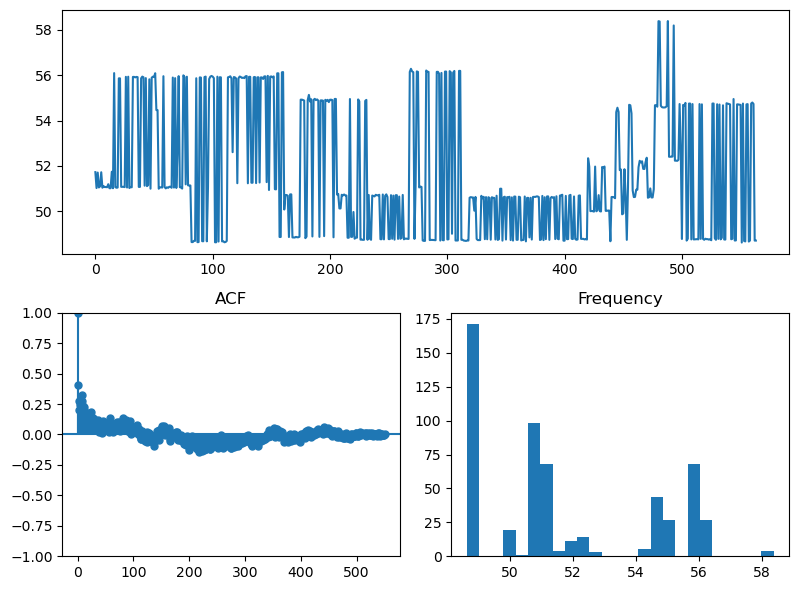

In [7]:
from pmdarima.utils import tsdisplay
tsdisplay(df_arima, lag_max=550)

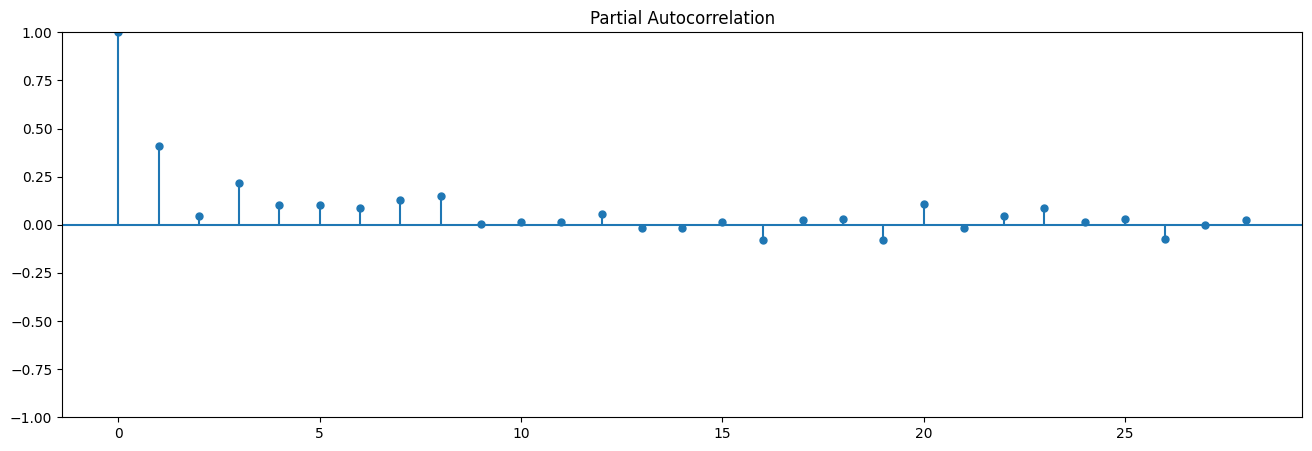

In [6]:
pm.plot_pacf(df_arima)

In [7]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_arima)  
print(p_val,should_diff)

0.01 False


In [8]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(df_arima, test='adf') 
print(n_adf)

0


In [9]:
#split training and test data 
train = df_arima.loc[df_arima.index <= '2023-01-18']
test = df_arima.loc[df_arima.index >= '2023-01-18']
test

,avg
new_time,
2023-01-18 00:02:39,50.630757
2023-01-18 00:07:39,50.622346
2023-01-18 00:12:39,50.576749
2023-01-18 00:17:39,54.370250
2023-01-18 00:22:39,54.563369
...,...
2023-01-18 09:52:39,54.746530
2023-01-18 09:57:39,54.792445
2023-01-18 10:02:39,54.728991


In [10]:
#Importing the module
import pmdarima as pm

#first model 
arima_model = pm.auto_arima(train, start_p=0,start_q=0,test="adf",trace=True,error_action='ignore',supress_warnings = True)

#Summary of the model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2153.804, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2059.229, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2071.116, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4733.150, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2060.134, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2046.975, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2056.047, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2032.426, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2069.169, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2026.386, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2031.900, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2030.299, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2019.094, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2061.848, Time=0.03 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  441
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -1003.547
Date:                Thu, 16 Mar 2023   AIC                           2019.094
Time:                        17:41:34   BIC                           2043.628
Sample:                    01-16-2023   HQIC                          2028.772
                         - 01-17-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.7985      2.104      2.281      0.023       0.675       8.922
ar.L1          0.9069      0.040     22.404      0.000       0.828       0.986
ma.L1         -0.5777      0.053    -10.874      0.000      -0.682      -0.474
ma.L2         -0.2772      0.052     -5.379      0.000      -0.378      -0.176
ma.L3          0.1434      0.040      3.619      0.000       0.066       0.221
sigma2         5.5194      0.574      9.622      0.000       4.395       6.644
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                15.72
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

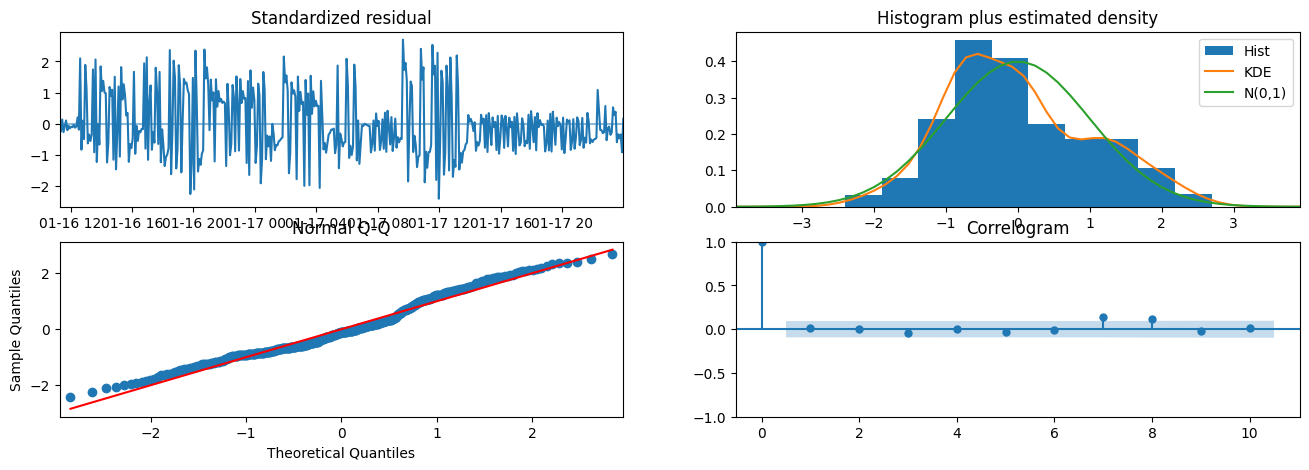

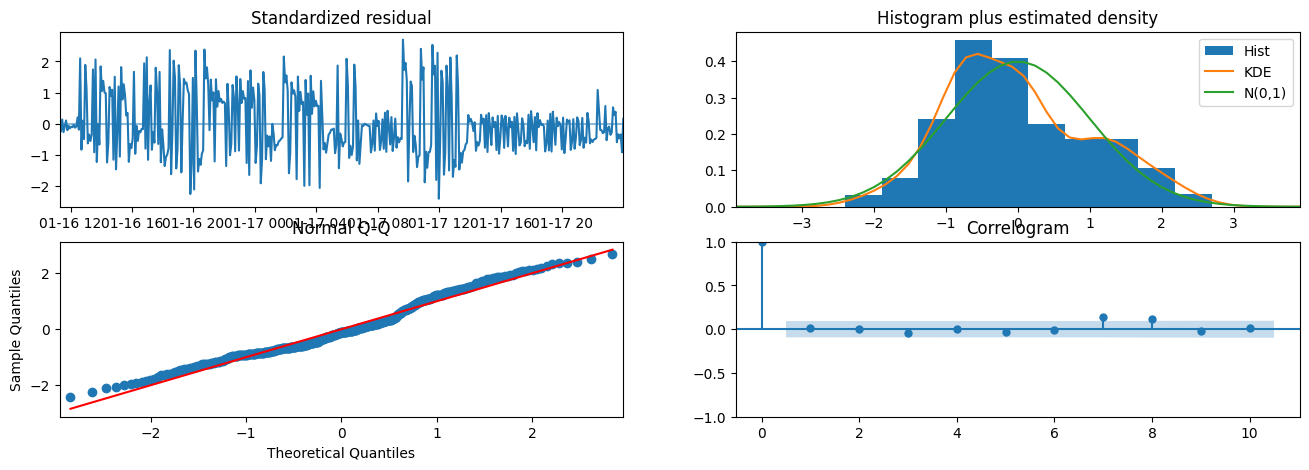

In [11]:
arima_model.plot_diagnostics()

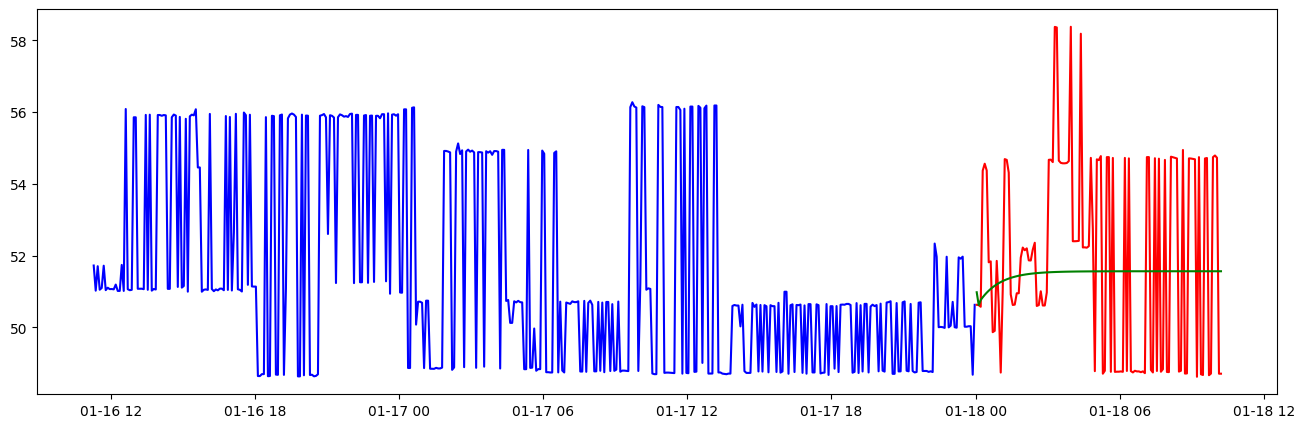

In [12]:
forecasts = arima_model.predict(test.shape[0])  

# Visualize the forecasts (blue=train,green=forecasts)
x = np.arange(df_arima.shape[0])
plt.plot(train, c='blue')
plt.plot(test,c = 'red')
plt.plot(forecasts, c='green')
plt.show()

In [13]:
forecasts.head()

2023-01-18 00:02:39    50.981265
2023-01-18 00:07:39    50.623580
2023-01-18 00:12:39    50.765253
2023-01-18 00:17:39    50.839812
2023-01-18 00:22:39    50.907433
Freq: 300S, dtype: float64

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_arima['avg'], order=(1,0,3))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    avg   No. Observations:                  564
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -1293.549
Date:                Thu, 16 Mar 2023   AIC                           2599.098
Time:                        17:41:35   BIC                           2625.108
Sample:                    01-16-2023   HQIC                          2609.251
                         - 01-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6874      0.545     94.754      0.000      50.618      52.757
ar.L1          0.9596      0.022     42.856      0.000       0.916       1.004
ma.L1         -0.6536      0.040    -16.208      0.0

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


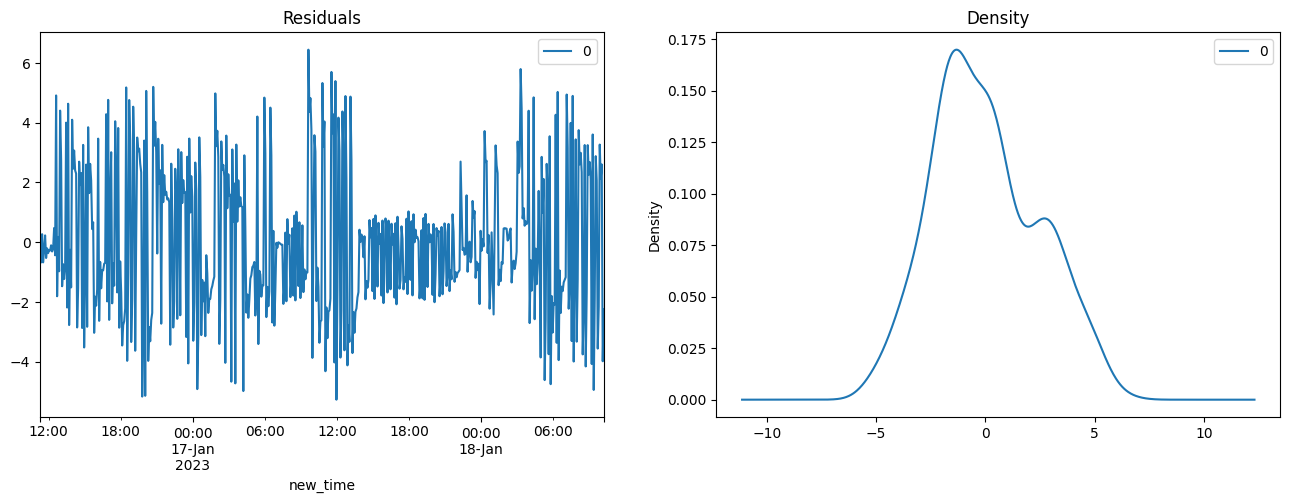

In [15]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

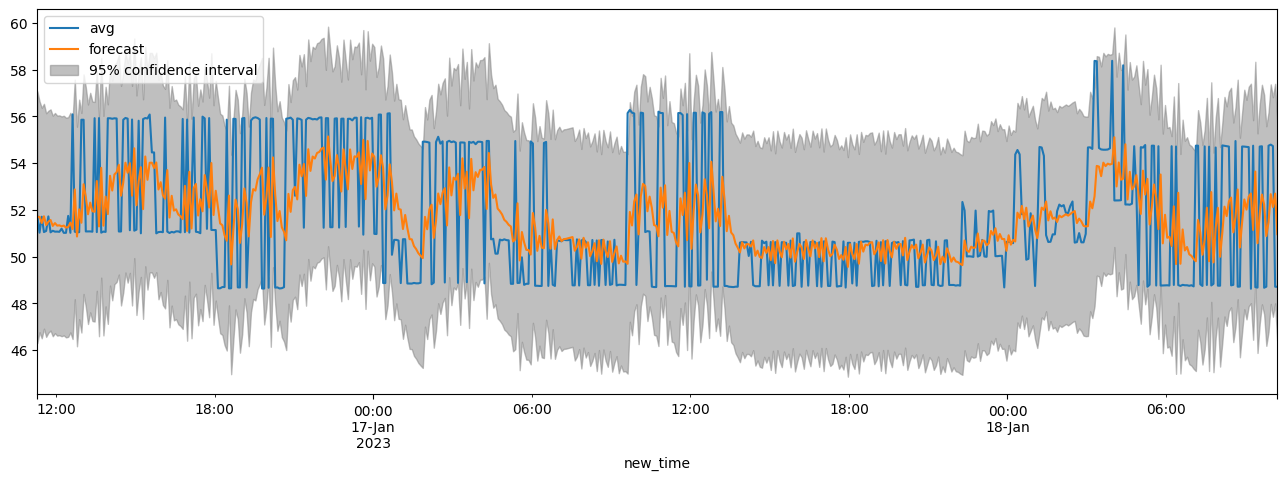

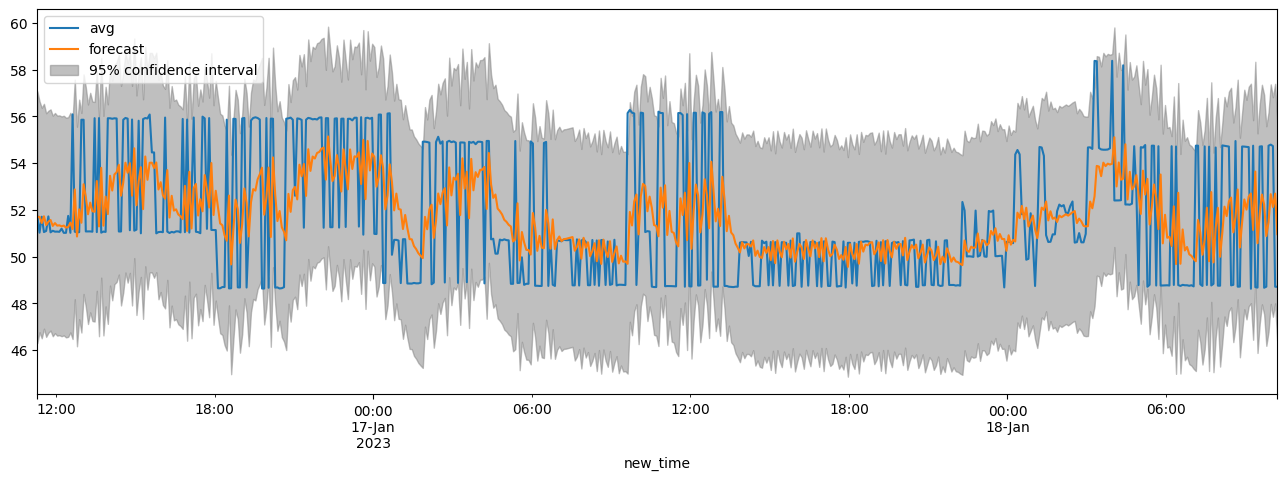

In [16]:
from statsmodels.graphics.tsaplots import plot_predict

# In-sample prediction
start = df_arima.index[0]
end = df_arima.index[-1]
pred = model_fit.predict(start=start, end=end, dynamic=False)

fig, ax = plt.subplots()
ax = df_arima.plot(ax=ax)
plot_predict(model_fit,start,end,ax=ax)



In [17]:
df_arima_new = df_arima.assign(pred = pred.values)
df_arima_new

,avg,pred
new_time,,
2023-01-16 11:17:39,51.726077,51.687436
2023-01-16 11:22:39,51.025667,51.702870
2023-01-16 11:27:39,51.706424,51.437539
2023-01-16 11:32:39,51.052043,51.727000
2023-01-16 11:37:39,51.100018,51.350541
...,...,...
2023-01-18 09:52:39,54.746530,51.477333
2023-01-18 09:57:39,54.792445,52.672818
2023-01-18 10:02:39,54.728991,52.124291


In [18]:
# checking the accuracy of the model 
se = (df_arima_new['pred']-df_arima_new['avg'])**2
se  = se.mean()
se

5.743697259305062